In [1]:
%load_ext jupyter_black
%matplotlib inline

Here we will test parameter recovery and model comparison for Rescorla-Wagner (RW), Hierarchical Gaussian Filters (HGF), and Switching Gaussian Filters (SGF) models of the social influence task.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", color_codes=True)


def posterior_accuracy(labels, df, vals, nsub):
    for i, lbl in enumerate(labels):
        std = (
            df.loc[df["parameter"] == lbl, ["subject", "value"]]
            .groupby(by="subject")
            .std()
        )
        mean = (
            df.loc[df["parameter"] == lbl, ["subject", "value"]]
            .groupby(by="subject")
            .mean()
        )
        print(
            lbl,
            np.sum(
                ((mean + 2 * std).values[:, 0] > vals[i])
                * ((mean - 2 * std).values[:, 0] < vals[i])
            )
            / (2 * nsub),
        )

Lets start by generating some behavioral data from the social influence task. Here green advice/choice is encoded as 0 and the blue advice/choice is encoded as 1.

In [3]:
import torch
from torch import tensor

from pybefit.tasks import SocialInfluence
from pybefit.simulate import Simulator
from pybefit.inference import NormalGamma as Prior
from pybefit.inference import NormalGammaPosterior as Posterior
from pybefit.agents.torch import RLSocInf, HGFSocInf, SGFSocInf
from pybefit.inference.methods import (
    run_svi,
    default_dict_pyro_svi,
    format_posterior_samples,
)
from pybefit.inference.models import PyroModel, PyroGuide
from pybefit.inference.pyro.likelihoods import befit_likelihood as likelihood

torch.manual_seed(1234)

nsub = 50  # number of subjects
trials = 120  # number of trials/responses


# transform from unconstrained parameters to constrained ones for any agent
def transform(z, model, *args, **kwargs):
    runs, _ = z.shape[-2:]
    # map z variables to model parameters
    agent = model(runs=runs, trials=trials)
    agent.set_parameters(z)

    return agent


# load stimuli (trial offers, advices, and reliability of advices)
reliability = torch.from_numpy(np.load("advice_reliability.npy")).float()
reliability = (
    reliability.reshape(trials, -1, 1)
    .repeat(1, 1, nsub)
    .reshape(trials, -1)
    .unsqueeze(0)
)

offers = (
    torch.from_numpy(np.load("offers.npy"))
    .reshape(trials, -1, 1)
    .repeat(1, 1, nsub)
    .reshape(trials, -1)
    .unsqueeze(0)
)

stimuli = {"offers": offers, "reliability": reliability}

# RL agent
trans_pars1 = torch.arange(-1.0, 1.0, 2.0 / (2 * nsub)).reshape(-1, 1) + tensor(
    [[-2.0, 2.0, 2.0, 0.0]]
)
rl_agent = transform(trans_pars1, RLSocInf)

# HGF agent
hgf_agent = HGFSocInf(runs=2 * nsub, trials=trials)

trans_pars2 = torch.arange(-1.0, 1.0, 2.0 / (2 * nsub)).reshape(-1, 1) + tensor(
    [[0.0, 0.0, 2.0, 2.0, 0.0]]
)
hgf_agent = transform(trans_pars2, HGFSocInf)

# SGF agent
sgf_agent = SGFSocInf(runs=2 * nsub, trials=trials)

trans_pars3 = torch.arange(-1.0, 1.0, 2.0 / (2 * nsub)).reshape(-1, 1) + tensor(
    [[-1.0, 0.0, 2.0, 2.0, 0.0]]
)
sgf_agent = transform(trans_pars3, SGFSocInf)

# simulate behaviour
sim = Simulator(
    [
        SocialInfluence(stimuli, nsub=nsub),
        SocialInfluence(stimuli, nsub=nsub),
        SocialInfluence(stimuli, nsub=nsub),
    ],
    [rl_agent, hgf_agent, sgf_agent],
    trials=trials,
)
sim.simulate_experiment()

stimuli, responses = sim.format_stimuli_and_responses()

plot performance of different agents in different blocks

RL agent:  [0.60833335 0.65      ]
HGF agent:  [0.60833335 0.65      ]
SGF agent:  [0.65 0.65]


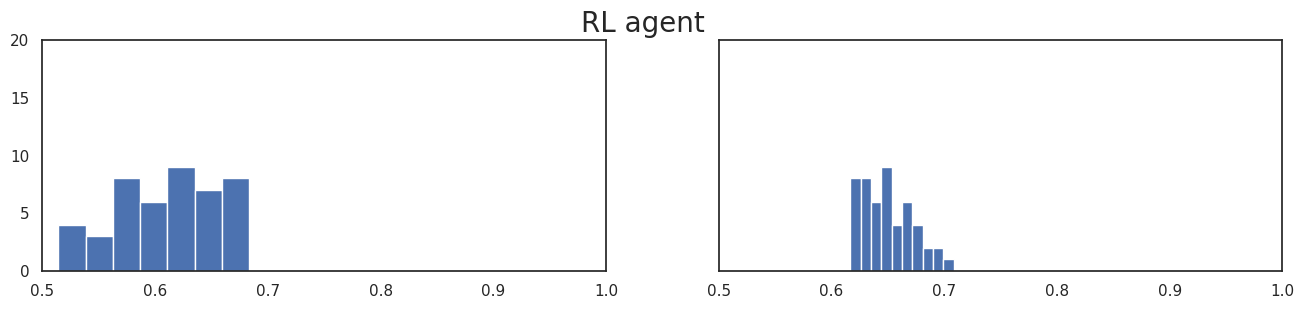

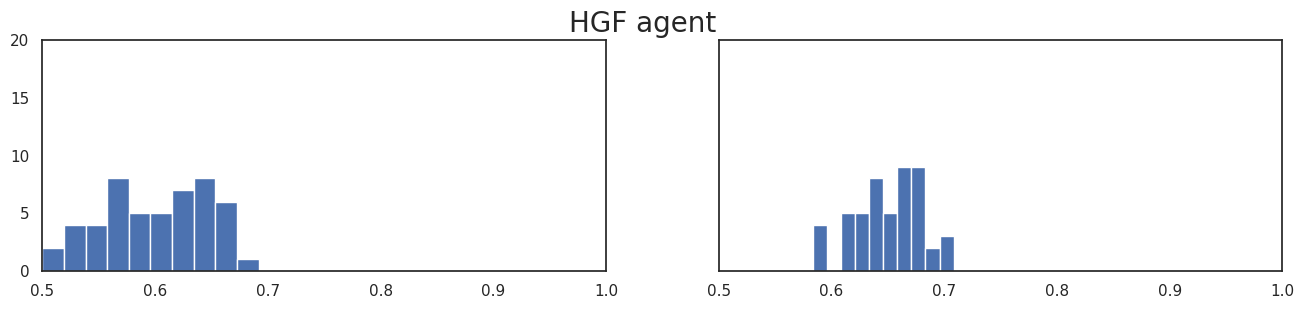

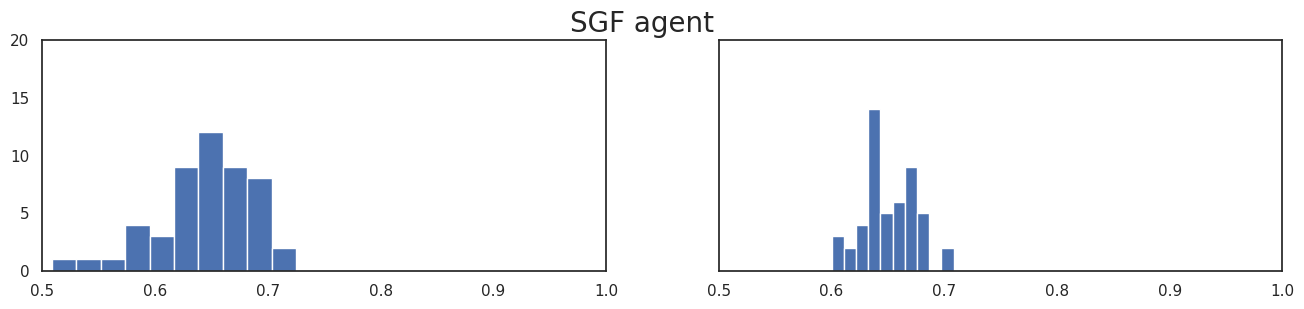

In [4]:
def compute_mean_performance(outcomes, responses):
    cc1 = (outcomes * responses > 0.0).float()  # accept reliable offer
    cc2 = (outcomes * (1 - responses) < 0.0).float()  # reject unreliable offer

    return torch.einsum("ijk->k", cc1 + cc2) / trials


perf1 = (
    compute_mean_performance(
        stimuli["pair_0"]["outcomes"][..., 0].float(), responses["pair_0"].float()
    )
    .numpy()
    .reshape(2, -1)
)

print("RL agent: ", np.median(perf1, axis=-1))

fig, ax = plt.subplots(1, 2, figsize=(16, 3), sharex=True, sharey=True)
ax[0].hist(perf1[0])
ax[1].hist(perf1[1])
fig.suptitle("RL agent", fontsize=20)
ax[0].set_ylim([0, 20])
ax[0].set_xlim([0.5, 1.0])

perf2 = (
    compute_mean_performance(
        stimuli["pair_1"]["outcomes"][..., 0].float(), responses["pair_1"].float()
    )
    .numpy()
    .reshape(2, -1)
)
print("HGF agent: ", np.median(perf2, axis=-1))

fig, ax = plt.subplots(1, 2, figsize=(16, 3), sharex=True, sharey=True)
ax[0].hist(perf2[0])
ax[1].hist(perf2[1])
fig.suptitle("HGF agent", fontsize=20)
ax[0].set_ylim([0, 20])
ax[0].set_xlim([0.5, 1.0])

perf3 = (
    compute_mean_performance(
        stimuli["pair_2"]["outcomes"][..., 0].float(), responses["pair_2"].float()
    )
    .numpy()
    .reshape(2, -1)
)
print("SGF agent: ", np.median(perf3, axis=-1))

fig, ax = plt.subplots(1, 2, figsize=(16, 3), sharex=True, sharey=True)
ax[0].hist(perf3[0])
ax[1].hist(perf3[1])
fig.suptitle("SGF agent", fontsize=20)
ax[0].set_ylim([0, 20])
ax[0].set_xlim([0.5, 1.0]);

Fit simulated behavior

In [9]:
transform_rl = lambda z, *args, **kwargs: transform(z, RLSocInf, *args, **kwargs)

measurments = stimuli["pair_0"]
measurments.update({"mask": torch.ones(1, 120, 100), "responses": responses["pair_0"]})

num_params = 4
num_agents = 2 * nsub
num_samples = 100

prior = Prior(num_params, num_agents, backend="pyro")

posterior = PyroGuide(Posterior(num_params, num_agents, backend="pyro"))


opts_task = {"num_blocks": 1, "num_trials": trials, "num_agents": num_agents}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

rl_gen_model = PyroModel(prior, transform_rl, likelihood, opts=opts_model)


# perform inference using stochastic variational inference
opts_svi = default_dict_pyro_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 5_000})

samples, svi, results = run_svi(rl_gen_model, posterior, measurments, opts=opts_svi)
var_names = ["alpha", "zeta", "beta", "bias"]
tp_df, par_df = format_posterior_samples(var_names, samples, transform_rl)

  0%|          | 0/5000 [00:00<?, ?it/s]

Compute fit quality and plot posterior estimates from a hierarchical parameteric model

In [13]:
labels = [r"$\alpha$", r"$\zeta$", r"$\beta$", r"$\theta$"]
trans_pars_rl = tp_df.melt(id_vars="subject", var_name="parameter")

vals = [
    trans_pars1[:, 0].numpy(),
    trans_pars1[:, 1].numpy(),
    trans_pars1[:, 2].numpy(),
    trans_pars1[:, 3].numpy(),
]
posterior_accuracy(var_names, trans_pars_rl, vals, nsub)

alpha 0.98
zeta 0.99
beta 0.99
bias 0.98


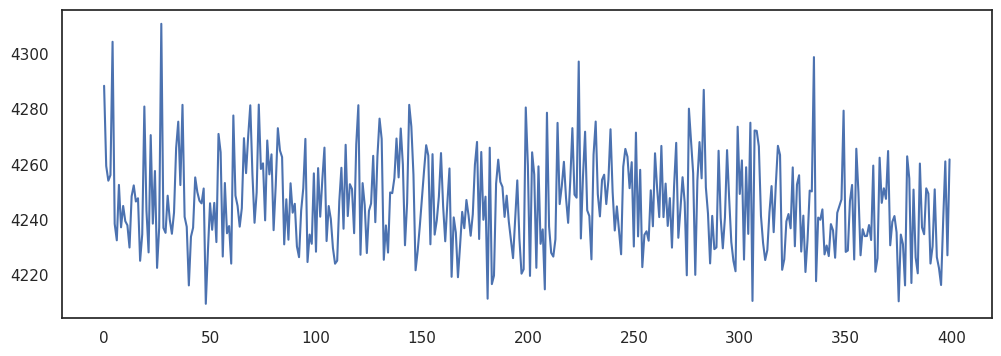

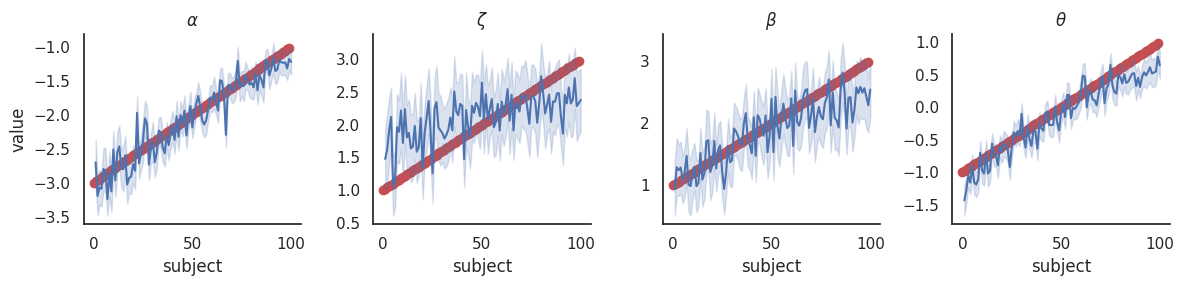

In [14]:
plt.figure(figsize=(12, 4))
# plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(results["loss"][-400:])

g = sns.FacetGrid(trans_pars_rl, col="parameter", height=3, sharey=False)
g = g.map(sns.lineplot, "subject", "value", errorbar="sd")

labels = [r"$\alpha$", r"$\zeta$", r"$\beta$", r"$\theta$"]
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2 * nsub), trans_pars1[:, i].numpy(), "ro", zorder=0)
    g.axes[0, i].set_title(labels[i])

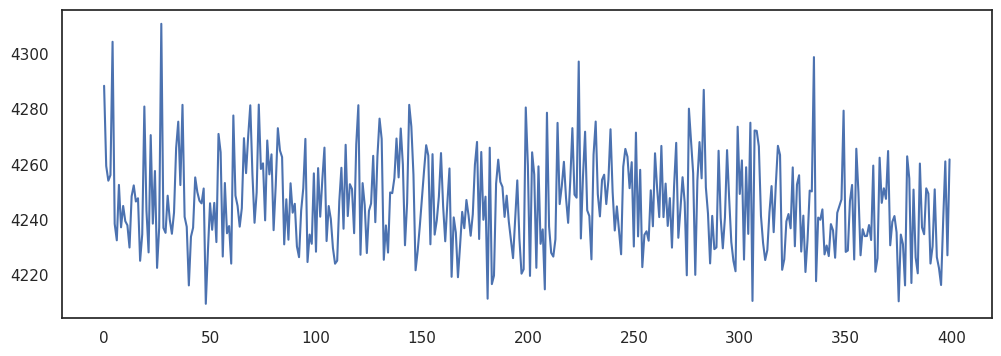

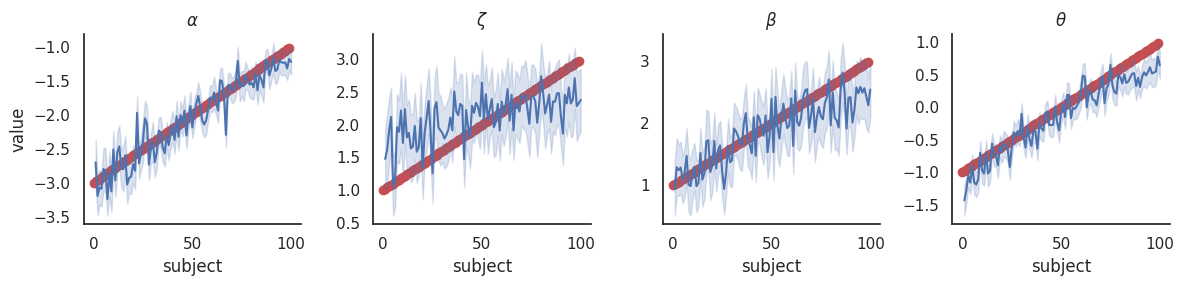

In [15]:
plt.figure(figsize=(12, 4))
# plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(results["loss"][-400:])

g = sns.FacetGrid(trans_pars_rl, col="parameter", height=3, sharey=False)
g = g.map(sns.lineplot, "subject", "value", errorbar="sd")

labels = [r"$\alpha$", r"$\zeta$", r"$\beta$", r"$\theta$"]
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2 * nsub), trans_pars1[:, i].numpy(), "ro", zorder=0)
    g.axes[0, i].set_title(labels[i])

fit HGF agent to simulated data

In [16]:
transform_hgf = lambda z, *args, **kwargs: transform(z, HGFSocInf, *args, **kwargs)

measurments = stimuli["pair_1"]
measurments.update({"mask": torch.ones(1, 120, 100), "responses": responses["pair_1"]})

num_params = 5
num_agents = 2 * nsub
num_samples = 100

prior = Prior(num_params, num_agents, backend="pyro")

posterior = PyroGuide(Posterior(num_params, num_agents, backend="pyro"))

opts_task = {"num_blocks": 1, "num_trials": trials, "num_agents": num_agents}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

hgf_gen_model = PyroModel(prior, transform_hgf, likelihood, opts=opts_model)

# perform inference using stochastic variational inference
opts_svi = default_dict_pyro_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 5_000})

samples, svi, results = run_svi(hgf_gen_model, posterior, measurments, opts=opts_svi)
var_names = ["mu0_2", "eta", "zeta", "beta", "bias"]
hgf_tp_df, hgf_par_df = format_posterior_samples(var_names, samples, transform_hgf)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [17]:
trans_pars_hgf = hgf_tp_df.melt(id_vars="subject", var_name="parameter")

vals = [trans_pars2[:, i].numpy() for i in range(len(var_names))]
posterior_accuracy(var_names, trans_pars_hgf, vals, nsub)

mu0_2 0.85
eta 1.0
zeta 0.96
beta 0.96
bias 0.99


Plot posterior estimates from simulated data for the HGF agent

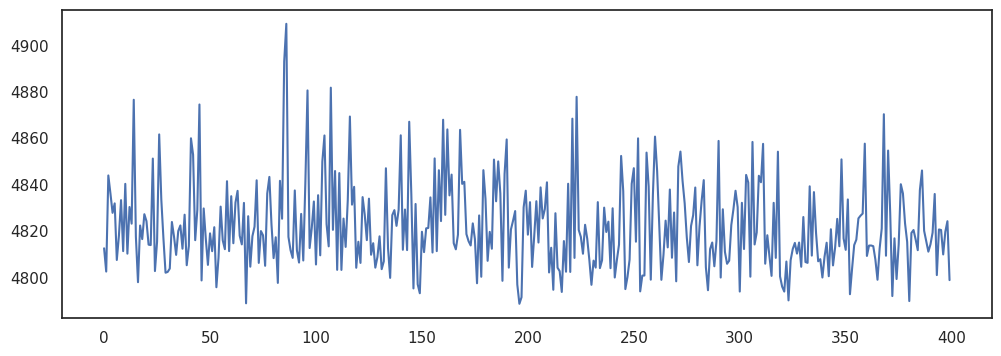

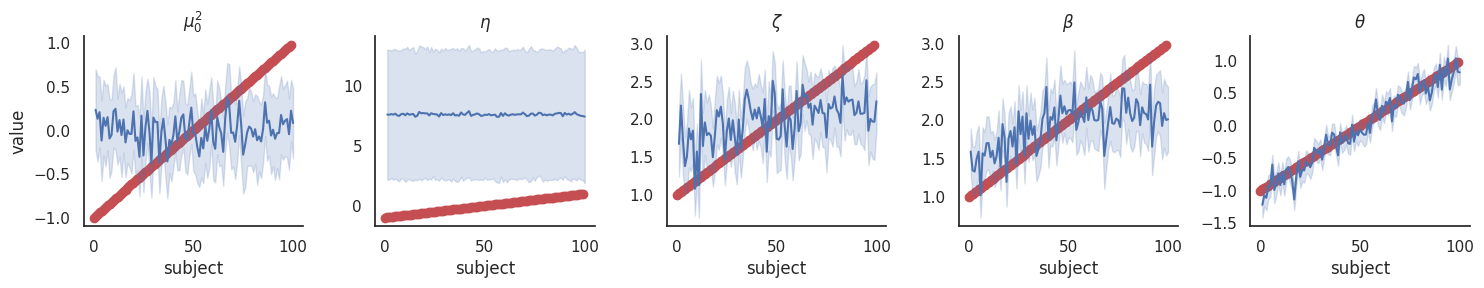

In [18]:
plt.figure(figsize=(12, 4))
# plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(results["loss"][-400:])

g = sns.FacetGrid(trans_pars_hgf, col="parameter", height=3, sharey=False)
g = g.map(sns.lineplot, "subject", "value", errorbar="sd")

labels = [r"$\mu_0^2$", r"$\eta$", r"$\zeta$", r"$\beta$", r"$\theta$"]
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2 * nsub), trans_pars2[:, i].numpy(), "ro", zorder=0)
    g.axes[0, i].set_title(labels[i])

In [19]:
transform_sgf = lambda z, *args, **kwargs: transform(z, SGFSocInf, *args, **kwargs)

measurments = stimuli["pair_2"]
measurments.update({"mask": torch.ones(1, 120, 100), "responses": responses["pair_2"]})

num_params = 5
num_agents = 2 * nsub
num_samples = 100

prior = Prior(num_params, num_agents, backend="pyro")

posterior = PyroGuide(Posterior(num_params, num_agents, backend="pyro"))

opts_task = {"num_blocks": 1, "num_trials": trials, "num_agents": num_agents}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

sgf_gen_model = PyroModel(prior, transform_sgf, likelihood, opts=opts_model)

# perform inference using stochastic variational inference
opts_svi = default_dict_pyro_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 5_000})

samples, svi, results = run_svi(sgf_gen_model, posterior, measurments, opts=opts_svi)
var_names = ["rho1", "h", "zeta", "beta", "bias"]
sgf_tp_df, sgf_par_df = format_posterior_samples(var_names, samples, transform_sgf)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [20]:
trans_pars_sgf = sgf_tp_df.melt(id_vars="subject", var_name="parameter")

vals = [trans_pars3[:, i].numpy() for i in range(len(var_names))]
posterior_accuracy(var_names, trans_pars_sgf, vals, nsub)

rho1 0.85
h 0.67
zeta 0.97
beta 0.99
bias 0.95


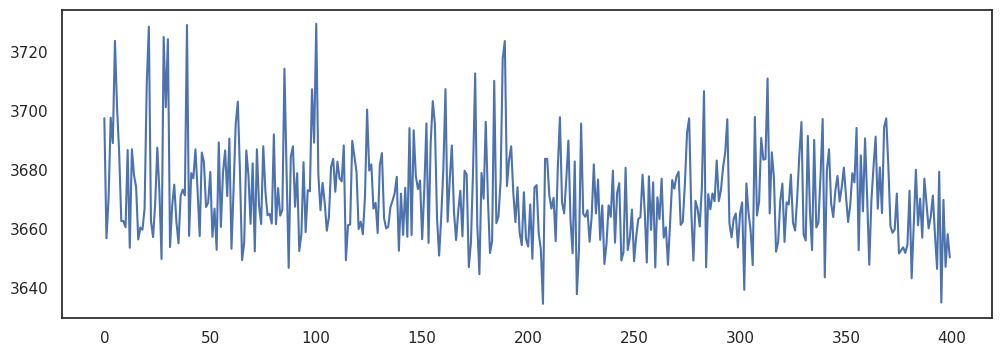

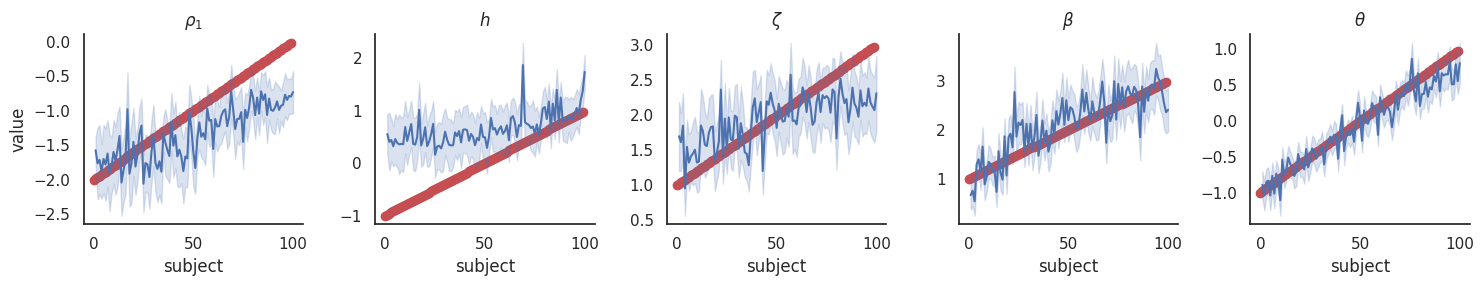

In [21]:
plt.figure(figsize=(12, 4))
# plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(results["loss"][-400:])

g = sns.FacetGrid(trans_pars_sgf, col="parameter", height=3, sharey=False)
g = g.map(sns.lineplot, "subject", "value", errorbar="sd")

labels = [r"$\rho_1$", r"$h$", r"$\zeta$", r"$\beta$", r"$\theta$"]
for i in range(len(labels)):
    g.axes[0, i].plot(np.arange(2 * nsub), trans_pars3[:, i].numpy(), "ro", zorder=0)
    g.axes[0, i].set_title(labels[i])

Test model comparison

In [7]:
from pybefit.inference.methods import get_log_evidence_per_subject

transform_rl = lambda z, *args, **kwargs: transform(z, RLSocInf, *args, **kwargs)
transform_hgf = lambda z, *args, **kwargs: transform(z, HGFSocInf, *args, **kwargs)
transform_sgf = lambda z, *args, **kwargs: transform(z, SGFSocInf, *args, **kwargs)


num_samples = 100
num_agents = 2 * nsub

opts_svi = default_dict_pyro_svi
opts_svi.update({"sample_kwargs": {"num_samples": num_samples}, "iter_steps": 1_000})

opts_task = {"num_blocks": 1, "num_trials": trials, "num_agents": num_agents}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

num_params = 4
prior = Prior(num_params, num_agents, backend="pyro")
rl_posterior = PyroGuide(Posterior(num_params, num_agents, backend="pyro"))
rl_gen_model = PyroModel(prior, transform_rl, likelihood, opts=opts_model)

num_params = 5
prior = Prior(num_params, num_agents, backend="pyro")
hgf_posterior = PyroGuide(Posterior(num_params, num_agents, backend="pyro"))
hgf_gen_model = PyroModel(prior, transform_hgf, likelihood, opts=opts_model)

num_params = 5
prior = Prior(num_params, num_agents, backend="pyro")
sgf_posterior = PyroGuide(Posterior(num_params, num_agents, backend="pyro"))
sgf_gen_model = PyroModel(prior, transform_sgf, likelihood, opts=opts_model)

evidences = torch.zeros(3, 3, 2 * nsub)
for i, gen_model, posterior in zip(
    range(3),
    [rl_gen_model, hgf_gen_model, sgf_gen_model],
    [rl_posterior, hgf_posterior, sgf_posterior],
):
    for j in range(3):
        measurments = stimuli[f"pair_{j}"]
        measurments.update(
            {"mask": torch.ones(1, 120, 100), "responses": responses[f"pair_{j}"]}
        )
        samples, svi, results = run_svi(
            gen_model, posterior, measurments, opts=opts_svi
        )
        evidences[i, j] = get_log_evidence_per_subject(
            svi, num_agents, data=measurments
        )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
print((evidences[:, 0].argmax(dim=0) == 0).sum().float() / num_agents)
print((evidences[:, 1].argmax(dim=0) == 1).sum().float() / num_agents)
print((evidences[:, 2].argmax(dim=0) == 2).sum().float() / num_agents)
evidences.sum(-1)

tensor(0.2000)
tensor(0.9900)
tensor(0.1500)


tensor([[-4646.0664, -5254.4258, -4058.5942],
        [-4552.1719, -4979.0415, -4176.7051],
        [-4599.5464, -5203.9204, -4077.9834]])

The diagonal elements in the above matrix are not always the lowest values for the corresponding column, which shows that we cannot accuretly infer the correct model over population, and probably not per subject. More detailed analysis of the possible parameteric models is required.